#Projet A : Modèle spécialisé par cluster

#Introduction

L'analyse et la classification des comportements d'attaque sont cruciales pour la sécurité des systèmes informatiques. Le dataset CICIDS2017 fournit une opportunité unique d'explorer ces données et de développer des modèles spécialisés par cluster pour détecter efficacement les anomalies et prédire les menaces potentielles. Ce projet se concentre sur la préparation rigoureuse des données, l'application de techniques de clustering avancées, et l'entraînement de modèles de machine learning pour chaque cluster identifié. En utilisant des méthodes telles que K-Means, HDBSCAN, et Gaussian Mixture Model, nous explorons divers aspects de la détection d'anomalies et de l'interprétabilité des modèles, avec pour objectif final de créer des profils comportementaux robustes par cluster.

#Préparation des Données pour Clustering ***(Najlaa JOULALI)***##


### Description du Dataset
**Source** :Le dataset CICIDS2017 est une base de données reconnue pour l’étude de la cybersécurité, contenant des données réseau collectées via capture de paquets (PCAP) et extraites en format CSV pour faciliter l’analyse.

Pour notre travail, nous avons utilisé uniquement les données correspondant au scénario du mercredi. Ce scénario regroupe plusieurs flux réseau enregistrés au cours d’une journée typique, comprenant du trafic normal et des attaques.

**Contenu des données** :

Type: flux réseau, caractérisés par des attributs tels que les adresses IP source et destination, ports, protocoles, durées, nombres de paquets, débits, etc.

Format : CSV (valeurs séparées par des virgules) extrait des fichiers PCAP originaux.

Volume : Plusieurs milliers d’enregistrements, représentant différents événements réseau sur la journée.



**bold text**###Objectif de la Préparation des Données
Le but principal de cette étape est de préparer le dataset afin d’effectuer un clustering. Plus précisément :

**Explorer le comportement normal** : Isoler et analyser les flux de trafic qui ne sont pas associés à des attaques connues.

**Identifier des schémas** : Découvrir, via le clustering, des profils types ou groupes naturels dans les données, correspondant à différents comportements réseau légitimes.

**Faciliter la détection d’anomalies**: Ces profils serviront ensuite de référence pour détecter des écarts indicateurs d’attaques ou comportements suspects.



###Étape 1 : Chargement des bibliothèques nécessaires###

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from google.colab import files
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import os
import zipfile


###Étape 2 : Chargement du dataset


Pour travailler avec les données du scénario du mercredi du dataset CICIDS2017, nous avons suivi plusieurs étapes permettant de récupérer, décompresser, et charger les données dans notre environnement de travail Python.

L’accès aux données se fait via l’API Kaggle. La commande suivante permet d’uploader la clé d’authentification kaggle.json nécessaire à l’accès :

In [ ]:
uploaded = files.upload()


Saving kaggle.json to kaggle.json


Puis, nous créons le dossier .kaggle dans le répertoire root et y plaçons ce fichier, en appliquant les permissions sécurisées nécessaires :

In [ ]:
# Create kaggle folder and move the json token
os.makedirs("/root/.kaggle", exist_ok=True)
!cp kaggle.json /root/.kaggle/
os.chmod("/root/.kaggle/kaggle.json", 600)

Le dataset CICIDS2017 est ensuite téléchargé depuis Kaggle avec la commande suivante :

In [ ]:
!kaggle datasets download -d kk0105/cicids2017

Dataset URL: https://www.kaggle.com/datasets/kk0105/cicids2017
License(s): apache-2.0
 98% 276M/283M [00:00<00:00, 283MB/s]
100% 283M/283M [00:00<00:00, 356MB/s]


Le fichier compressé cicids2017.zip est décompressé dans le dossier cicids2017 :

In [ ]:
!unzip cicids2017.zip -d cicids2017

Archive:  cicids2017.zip
  inflating: cicids2017/MachineLearningCSV/MachineLearningCSV/MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv  
  inflating: cicids2017/MachineLearningCSV/MachineLearningCSV/MachineLearningCVE/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv  
  inflating: cicids2017/MachineLearningCSV/MachineLearningCSV/MachineLearningCVE/Friday-WorkingHours-Morning.pcap_ISCX.csv  
  inflating: cicids2017/MachineLearningCSV/MachineLearningCSV/MachineLearningCVE/Monday-WorkingHours.pcap_ISCX.csv  
  inflating: cicids2017/MachineLearningCSV/MachineLearningCSV/MachineLearningCVE/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv  
  inflating: cicids2017/MachineLearningCSV/MachineLearningCSV/MachineLearningCVE/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv  
  inflating: cicids2017/MachineLearningCSV/MachineLearningCSV/MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv  
  inflating: cicids2017/MachineLearningCSV/MachineLearningCSV/Mach

Nous allons utiliser le fichier `Wednesday-workingHours.pcap_ISCX.csv` qui contient à la fois du trafic **normal** et **malveillant** (DoS Hulk, etc.).


In [ ]:
file_path = "cicids2017/MachineLearningCSV/MachineLearningCSV/MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv"
df = pd.read_csv(file_path)
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80,38308,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,389,479,11,5,172,326,79,0,15.636364,31.449238,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,88,1095,10,6,3150,3150,1575,0,315.000000,632.561635,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,389,15206,17,12,3452,6660,1313,0,203.058823,425.778474,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,88,1092,9,6,3150,3152,1575,0,350.000000,694.509719,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


### 2.1 Vérifier les informations des données

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692703 entries, 0 to 692702
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             692703 non-null  int64  
 1    Flow Duration                692703 non-null  int64  
 2    Total Fwd Packets            692703 non-null  int64  
 3    Total Backward Packets       692703 non-null  int64  
 4   Total Length of Fwd Packets   692703 non-null  int64  
 5    Total Length of Bwd Packets  692703 non-null  int64  
 6    Fwd Packet Length Max        692703 non-null  int64  
 7    Fwd Packet Length Min        692703 non-null  int64  
 8    Fwd Packet Length Mean       692703 non-null  float64
 9    Fwd Packet Length Std        692703 non-null  float64
 10  Bwd Packet Length Max         692703 non-null  int64  
 11   Bwd Packet Length Min        692703 non-null  int64  
 12   Bwd Packet Length Mean       692703 non-nul

Cette étape permet de comprendre la structure des données : 692 703 lignes, 79 colonnes majoritairement numériques, avec très peu de valeurs manquantes. Elle confirme que le dataset est volumineux mais propre, ce qui facilite le traitement.


Il faudra gérer les rares valeurs manquantes, normaliser les variables numériques pour équilibrer les échelles, et encoder les variables catégorielles, notamment la colonne Label, avant d’appliquer le clustering. et c'est l;object de l'etape suivante

###  2.2 Vérifier les données manquantes ou corrompues

In [ ]:
# Count missing values
print(df.isnull().sum().sort_values(ascending=False).head(10))

# Check for non-standard missing markers like ?
print((df == '?').sum().sort_values(ascending=False).head(10))


Flow Bytes/s                    1008
 Flow Duration                     0
 Destination Port                  0
 Total Backward Packets            0
Total Length of Fwd Packets        0
 Total Length of Bwd Packets       0
 Total Fwd Packets                 0
 Fwd Packet Length Max             0
 Fwd Packet Length Min             0
 Fwd Packet Length Std             0
dtype: int64
 Destination Port               0
 Flow Duration                  0
 Total Fwd Packets              0
 Total Backward Packets         0
Total Length of Fwd Packets     0
 Total Length of Bwd Packets    0
 Fwd Packet Length Max          0
 Fwd Packet Length Min          0
 Fwd Packet Length Mean         0
 Fwd Packet Length Std          0
dtype: int64


Le résultat montre que seule la colonne Flow Bytes/s contient 1008 valeurs manquantes sur 692 703 entrées, soit une proportion très faible (moins de 0,15%). Toutes les autres colonnes sont complètes.

Cette faible quantité de données manquantes peut être facilement gérée sans impacter significativement l’analyse.

On peut envisager soit de supprimer ces lignes, soit d’imputer les valeurs manquantes (par exemple, par la moyenne ou la médiane).

In [ ]:
print("\n Aperçu du dataset :")
display(df.head())
print(f"\n  Dimensions : {df.shape[0]} lignes, {df.shape[1]} colonnes")


 Aperçu du dataset :


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80,38308,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,389,479,11,5,172,326,79,0,15.636364,31.449238,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,88,1095,10,6,3150,3150,1575,0,315.000000,632.561635,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,389,15206,17,12,3452,6660,1313,0,203.058823,425.778474,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,88,1092,9,6,3150,3152,1575,0,350.000000,694.509719,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN



  Dimensions : 692703 lignes, 79 colonnes


###Étape 3 : Prétraitement des données

Nous supprimons les colonnes inutiles, gérons les valeurs manquantes et normalisons les données numériques pour le clustering.

In [ ]:
print("\n Suppression des doublons et des valeurs manquantes...")
df = df.drop_duplicates()
df = df.dropna()
print(f" Données après nettoyage : {df.shape}")


 Suppression des doublons et des valeurs manquantes...
 Données après nettoyage : (610733, 79)


###Étape 4 : Encodage des variables catégorielles###

####4.1 Encodage de la Variable Catégorielle

Le dataset contient une colonne appelée Label qui identifie si un flux réseau est normal (BENIGN) ou correspond à une attaque. Cette variable est de type catégoriel (chaîne de caractères), ce qui n’est pas directement exploitable par les algorithmes de clustering, qui attendent des valeurs numériques.

Pour y remédier, nous avons procédé à un encodage numérique à l’aide de la classe LabelEncoder de la bibliothèque sklearn.

In [ ]:
if 'Label' in df.columns:
    print("\n Encodage de la variable 'Label'...")
    encoder = LabelEncoder()
    df['Label'] = encoder.fit_transform(df['Label'])  # normal = 1, attack = 0
    print(f"Valeurs uniques dans Label : {encoder.classes_}")


####4.2 Sélection des Variables Numériques
Les méthodes de clustering (comme K-means) nécessitent uniquement des données numériques. Pour cette raison, nous avons identifié toutes les colonnes de type numérique dans le dataset, en excluant la variable cible Label afin de ne pas biaiser les résultats du clustering.

In [ ]:
# 📋 Sélection des colonnes numériques
colonnes_numeriques = df.select_dtypes(include='number').columns.tolist()

# 🧾 Exclure la variable cible 'Label' si elle est dans la liste
colonnes_numeriques_sans_label = [col for col in colonnes_numeriques if col != 'Label']

###Étape 5 : Standardisation des colonnes numériques###

La standardisation est une étape importante dans le prétraitement des données, notamment avant l’application des algorithmes de clustering. Ces algorithmes sont sensibles aux écarts d’échelle entre les variables : une variable avec une plage de valeurs plus large peut dominer la distance euclidienne utilisée pour regrouper les données.

Avant d’appliquer la standardisation, nous avons d’abord vérifié et supprimé les valeurs infinies qui pourraient altérer la qualité des résultats. Les infinis positifs et négatifs ont été remplacés par des valeurs manquantes (NaN), puis ces lignes ont été supprimées :

In [ ]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

print(f" Dimensions après suppression des infinis : {df.shape}")


 Dimensions après suppression des infinis : (610492, 79)


In [ ]:
# Standardisation des colonnes numériques
scaler = StandardScaler()
df[colonnes_numeriques_sans_label] = scaler.fit_transform(df[colonnes_numeriques_sans_label])


La standardisation a ensuite été réalisée à l’aide du module StandardScaler de sklearn, qui transforme les données pour qu’elles aient une moyenne nulle (0) et un écart type unitaire (1). Cette transformation permet de s’assurer que chaque variable contribue équitablement au calcul des distances lors du clustering.


###Étape 6 : Visualisation – Carte de chaleur des corrélations###

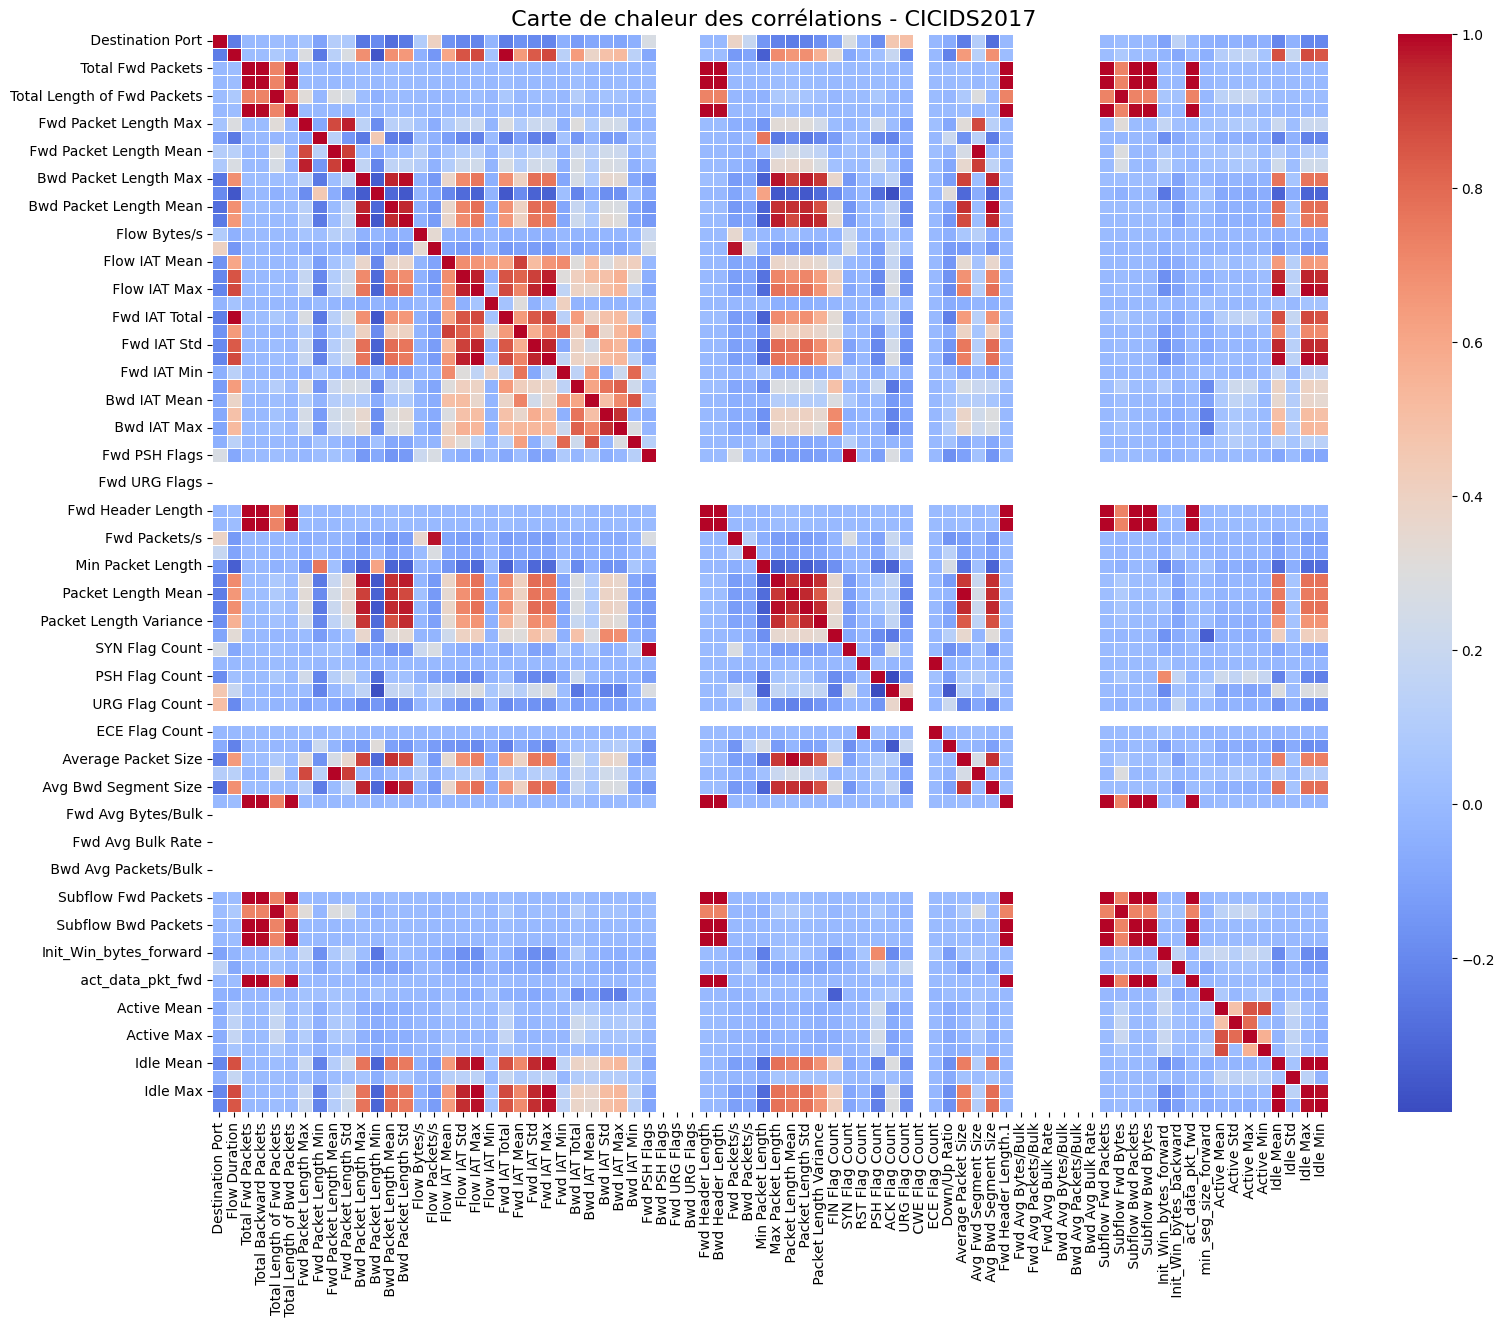

In [ ]:
#  Carte de chaleur des corrélations
plt.figure(figsize=(18, 14))
correlation_matrix = df.corr(numeric_only=True)
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title(' Carte de chaleur des corrélations - CICIDS2017', fontsize=16)
plt.show()


Le dataset CICIDS2017 est une base de données reconnue pour l’étude de la cybersécurité, contenant des données réseau collectées via capture de paquets (PCAP) et extraites en format CSV pour faciliter l’analyse.

Pour notre travail, nous avons utilisé uniquement les données correspondant au scénario du mercredi. Ce scénario regroupe plusieurs flux réseau enregistrés au cours d’une journée typique, comprenant du trafic normal et des attaques.

**Analyse des groupes de corrélations**
Cluster des caractéristiques de paquets (r > 0.8)
Les métriques liées aux longueurs de paquets présentent des intercorrélations exceptionnellement élevées :

Forward Packet Length Max/Mean et Backward Packet Length Max/Mean : corrélations supérieures à 0.9
Total Length of Forward Packets : fortement corrélé avec les métriques individuelles de longueur
Packet Length Mean/Variance : relations linéaires quasi-parfaites

Interprétation : Cette forte redondance suggère que ces variables capturent essentiellement la même information comportementale. Dans le contexte du scénario mercredi, cela indique que la taille des paquets suit des patterns cohérents, qu'il s'agisse de trafic normal ou malveillant.

**Groupe temporel - Inter-Arrival Time (0.6 < r < 0.9)**
Les métriques temporelles forment un second cluster cohérent :

Flow IAT Mean/Max/Min : corrélations internes fortes
Forward/Backward IAT : relations bidirectionnelles significatives
Flow Duration : modérément corrélé aux métriques IAT

Interprétation : Ces corrélations révèlent la nature rythmée des communications réseau. Les attaques présentes dans le scénario mercredi (DoS, infiltration) peuvent perturber ces patterns temporels naturels, créant des signatures détectables.

**Métriques de transfert en bloc (r > 0.7)**

Average Packet Size et Avg Bwd Segment Size : corrélation très forte
Bulk Rate features : cohérence interne élevée
Flow Bytes/s : corrélé aux métriques de taille

Interprétation : Ces corrélations reflètent les caractéristiques des transferts de données volumineux, particulièrement pertinentes pour détecter les attaques par déni de service ou les exfiltrations de données présentes dans le dataset.

**Variables à faible corrélation - Indicateurs spécialisés**

** TCP Flags (r < 0.3)**

Les compteurs de drapeaux TCP (SYN, PSH, URG, ECE) montrent des corrélations faibles avec la majorité des autres métriques :

Indépendance statistique quasi-totale
Patterns de distribution distincts
Information comportementale unique

Interprétation critique : Cette faible corrélation est en réalité un atout majeur. Les flags TCP capturent des comportements protocolaires spécifiques (établissement de connexion, urgence, contrôle de flux) essentiels pour identifier les attaques de type port scanning, SYN flooding, ou manipulation protocolaire présentes dans le scénario mercredi.

**Port et métadonnées de flux**

Destination Port : corrélations négligeables
Header Length : modérément indépendant
Flag Counts : patterns distincts

**Implications pour la détection d'intrusions**

**Optimisation de la sélection de caractéristiques**

Stratégie de réduction dimensionnelle :

Appliquer une analyse en composantes principales (PCA) sur le cluster des longueurs de paquets
Conserver un représentant par groupe de variables fortement corrélées
Maintenir l'intégralité des TCP flags malgré leur faible corrélation

Justification : La redondance informationnelle des métriques de paquets peut créer du sur-apprentissage, tandis que les flags TCP apportent une information discriminante irremplaçable.

** Construction de nouvelles caractéristiques**

Les patterns de corrélation suggèrent la création de features composites :

Ratio Forward/Backward Packet Length : exploiter la corrélation bidirectionnelle
Indice de régularité temporelle : combinaison des métriques IAT
Score d'anomalie protocolaire : agrégation pondérée des flags TCP

**Adaptation aux spécificités du scénario mercredi**
Le scénario mercredi du CICIDS2017 inclut :

Trafic normal : navigation web, emails, transferts FTP
Attaques DoS/DDoS : détectables via les métriques temporelles et de volume
Infiltration : identifiable par les anomalies de flags TCP et patterns de connexion
Brute Force : révélée par les métriques de connexion et ports

Les corrélations observées reflètent cette diversité comportementale et confirment la pertinence de l'approche multi-dimensionnelle.

###Étape 7 : Visualisation – Distribution d’une variable###

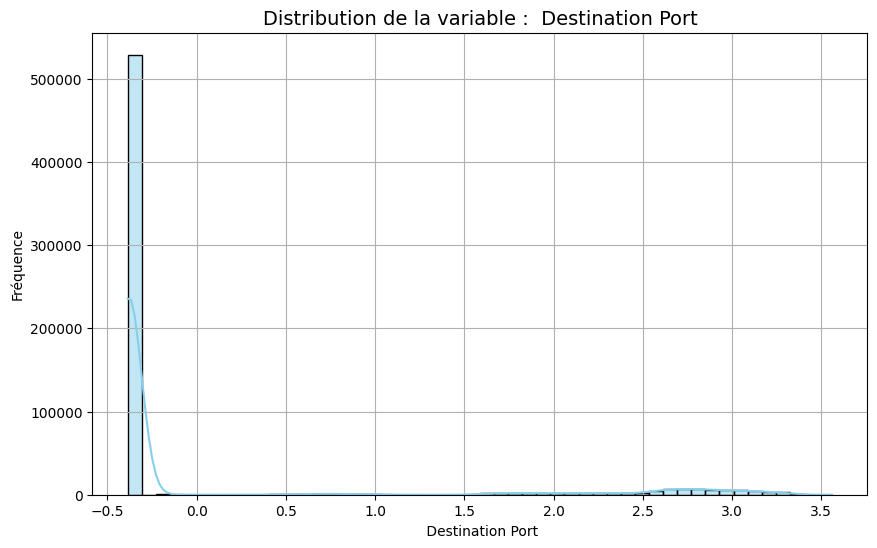

In [ ]:
#  Distribution d'une variable continue (par exemple 'Flow Duration')
variable = 'Flow Duration' if 'Flow Duration' in df.columns else df.select_dtypes(include='number').columns[0]

plt.figure(figsize=(10, 6))
sns.histplot(df[variable], bins=50, kde=True, color='skyblue')
plt.title(f'Distribution de la variable : {variable}', fontsize=14)
plt.xlabel(variable)
plt.ylabel('Fréquence')
plt.grid(True)
plt.show()


**Observations principales**

**Distribution fortement asymétrique :**

Pic dominant autour de -0.5 avec ~530,000 occurrences
Queue longue s'étendant jusqu'à 3.5
Distribution log-normale typique des données de ports réseau

**Interprétation technique**

**1. Concentration sur ports standards : **

La forte concentration près de -0.5 (après normalisation) suggère une prédominance des ports well-known (0-1023)
Ports typiques : HTTP (80), HTTPS (443), DNS (53), FTP (21)

**2. Ports dynamiques/éphémères :**

La queue étendue représente les ports hauts (>1024) utilisés pour les connexions client
Distribution caractéristique du trafic client-serveur normal

**Implications pour la cybersécurité**

**Détection d'anomalies :**

Les valeurs dans la queue (>2.0) peuvent indiquer :

Port scanning : tentatives sur ports non-standards
Backdoors : communications sur ports inhabituels
Tunneling : utilisation de ports alternatifs



**Cohérence avec CICIDS2017 mercredi :**

La distribution reflète le mélange trafic normal/malveillant
Les attaques de reconnaissance (port scan) génèrent des accès à des ports peu fréquents

# Clustering des comportements d’attaque — CICIDS2017(Aicha NASIH)
>  Aicha NASIH

Dans cette section, nous allons appliquer des algorithmes de clustering (KMeans, GMM, etc.) sur un sous-ensemble du dataset CICIDS2017 contenant **des attaques**.
L'objectif est d'identifier automatiquement des comportements suspects ou malveillants à travers une approche non supervisée.


## Installation et import des bibliothèques nécessaires

On importe les bibliothèques utiles pour la préparation, le clustering, la réduction de dimension et la visualisation.

In [ ]:
!pip install hdbscan
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import warnings
import hdbscan

## Chargement et vérification des données pré-traitées

In [ ]:
print("Dimensions du dataset :", df.shape)
print("\nAperçu des données :")
display(df.head())

Dimensions du dataset : (610492, 79)

Aperçu des données :


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,-0.382148,-0.717511,-0.012011,-0.010062,-0.094511,-0.008075,-0.404394,-0.234999,-0.374863,-0.393698,...,-0.988221,-0.140394,-0.107015,-0.1586,-0.111253,-0.632271,-0.112663,-0.638282,-0.621778,BENIGN
1,-0.363520,-0.718367,0.000553,-0.006246,-0.069214,-0.007940,-0.289659,-0.384941,-0.315657,-0.261950,...,0.885786,-0.140394,-0.107015,-0.1586,-0.111253,-0.632271,-0.112663,-0.638282,-0.621778,BENIGN
2,-0.381665,-0.718353,-0.000703,-0.005293,0.384609,-0.006758,2.061624,-0.384941,1.523651,2.256233,...,0.885786,-0.140394,-0.107015,-0.1586,-0.111253,-0.632271,-0.112663,-0.638282,-0.621778,BENIGN
3,-0.363520,-0.718034,0.008092,0.000431,0.430632,-0.005287,1.649835,-0.384941,0.835878,1.389976,...,0.885786,-0.140394,-0.107015,-0.1586,-0.111253,-0.632271,-0.112663,-0.638282,-0.621778,BENIGN
4,-0.381665,-0.718353,-0.001959,-0.005293,0.384609,-0.006757,2.061624,-0.384941,1.738693,2.515746,...,0.885786,-0.140394,-0.107015,-0.1586,-0.111253,-0.632271,-0.112663,-0.638282,-0.621778,BENIGN


## Sélection des features pour le clustering



Pour réduire les coûts de calcul, on sélectionne un échantillon aléatoire de 20 000 lignes.


In [ ]:
###  Création d’un échantillon pour le clustering ###
#  On prend un échantillon aléatoire de 20 000 lignes pour le clustering
taille_echantillon = 20000

df = df.sample(n=taille_echantillon, random_state=42) if df.shape[0] > taille_echantillon else df.copy()
print(f"Données utilisées pour le clustering : {df.shape}")

Données utilisées pour le clustering : (20000, 79)


Retiré la colonne 'Label' et appliqué PCA pour projeter les données en 2D pour la visualisation.

In [ ]:
df.columns = df.columns.str.strip()

# Suppression de la colonne 'Label' pour le clustering
X = df.drop(columns=['Label'])

# Réduction dimensionnelle pour visualisation 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)


## Application de K-Means

In [ ]:
# Choix arbitraire du nombre de clusters (à affiner via silhouette)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X)

# Ajout des clusters au dataframe
df['Cluster'] = clusters


## Visualisation des clusters

### Évaluation du Clustering
Un score > 0.5 indique des clusters bien définis, < 0.2 suggère un mauvais clustering

In [ ]:
#  Définition de la taille de l’échantillon à utiliser pour évaluer le clustering
sample_size = 20000

# Sélection aléatoire d’indices pour créer un sous-ensemble représentatif
idx = np.random.choice(len(X), size=sample_size, replace=False)

# Extraction cohérente des données et des labels de cluster correspondants
X_sample = X.iloc[idx]               # Utiliser .iloc pour indexer par position
clusters_sample = clusters[idx]     # clusters est un array, donc ça fonctionne directement

#  Application de la PCA pour réduire la dimension à 5 composantes avant évaluation
X_reduced = PCA(n_components=5).fit_transform(X_sample)

# Calcul du Silhouette Score
silhouette = silhouette_score(X_reduced, clusters_sample)
print(f"Silhouette Score (PCA + échantillon): {silhouette:.3f}")


Silhouette Score (PCA + échantillon): 0.623


Le Silhouette Score mesuré est de 0.623, ce qui est très satisfaisant.
En général :

* **> 0.5** : clusters bien formés et séparés

* **entre 0.3 et 0.5** : structure moyenne, améliorable

* **< 0.2** : clustering peu fiable ou données non séparables

 0.623 indique donc que les clusters sont cohérents et bien différenciés, avec peu de recouvrement entre eux. Cela suggère que l’algorithme K-Means a réussi à détecter des groupes significatifs dans le trafic réseau.



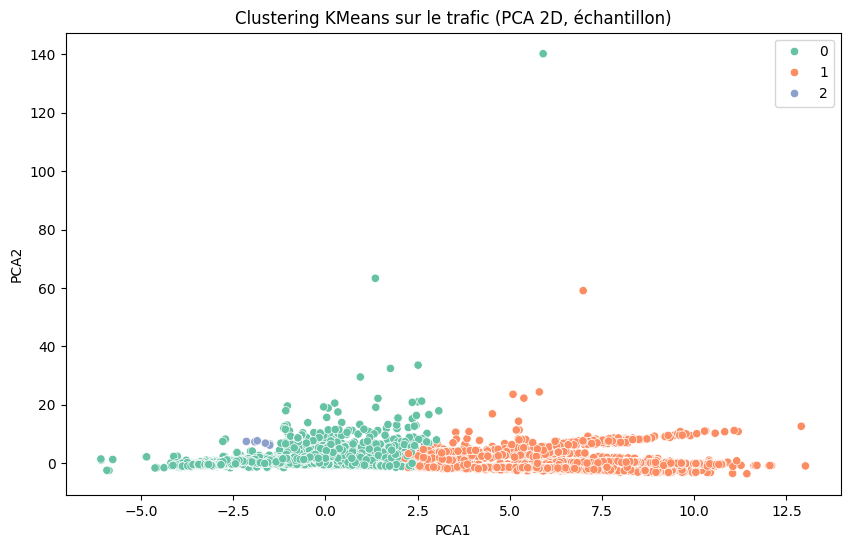

In [ ]:
# Make sure idx, X_pca_sample, and clusters_sample were already defined as in previous steps

# PCA on the sample
X_sample = X.iloc[idx]
X_pca_sample = PCA(n_components=2).fit_transform(X_sample)
clusters_sample = clusters[idx]

# Now plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca_sample[:, 0], y=X_pca_sample[:, 1], hue=clusters_sample, palette='Set2', legend='full')
plt.title('Clustering KMeans sur le trafic (PCA 2D, échantillon)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()



Le graphique représente une projection en 2D des données réduites via PCA, colorées selon les clusters attribués par K-Means :

* Chaque point représente un flux réseau (ou une session).

* Les couleurs distinguent les différents clusters : 0, 1, 2.

* On observe que :

  * Les clusters 0 et 1 sont bien séparés horizontalement, indiquant une bonne distinction sur la première composante principale.

  * Le cluster 2 (bleu) est très peu représenté, ce qui peut indiquer soit un groupe marginal (ex : un type d’attaque rare), soit un sous-groupe très spécifique.

↳ Ce type de visualisation est utile pour explorer visuellement la structure des données après clustering.

## Affinage du nombre de clusters (KMeans) avec le Silhouette Score
Nous allons tester plusieurs valeurs de k pour déterminer le meilleur nombre de clusters à l’aide du Silhouette Score.

➡️ k=2 → Silhouette Score = 0.656
➡️ k=3 → Silhouette Score = 0.434
➡️ k=4 → Silhouette Score = 0.408
➡️ k=5 → Silhouette Score = 0.335
➡️ k=6 → Silhouette Score = 0.336
➡️ k=7 → Silhouette Score = 0.336
➡️ k=8 → Silhouette Score = 0.305
➡️ k=9 → Silhouette Score = 0.324


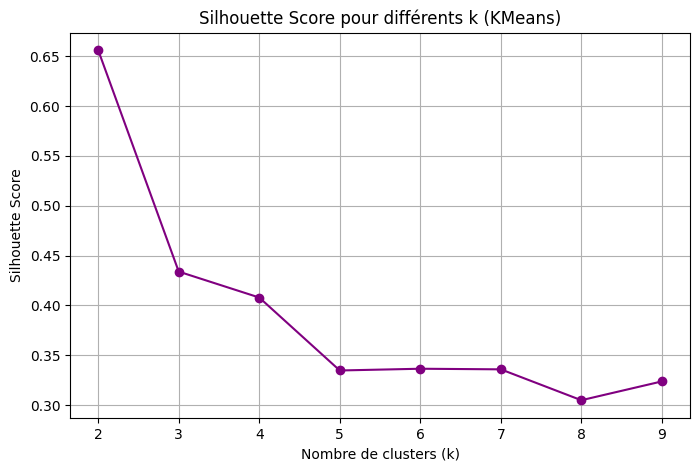

In [ ]:
# Tester différentes valeurs de k
range_k = range(2, 10)
scores = []

for k in range_k:
    model = KMeans(n_clusters=k, random_state=42)
    preds = model.fit_predict(X)
    score = silhouette_score(X, preds)
    scores.append(score)
    print(f"➡️ k={k} → Silhouette Score = {score:.3f}")

# Visualisation
plt.figure(figsize=(8, 5))
plt.plot(range_k, scores, marker='o', color='purple')
plt.title('Silhouette Score pour différents k (KMeans)')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()


### Graphe du Silhouette Score :
* Le Silhouette Score maximal est à k=2 (score ≈ 0.656).

* À partir de k=3, la qualité de séparation diminue nettement.

* Les scores restent faibles (≈ 0.3–0.4) pour k ≥ 5, ce qui indique des clusters mal définis ou trop proches.

## Clustering avec HDBSCAN

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


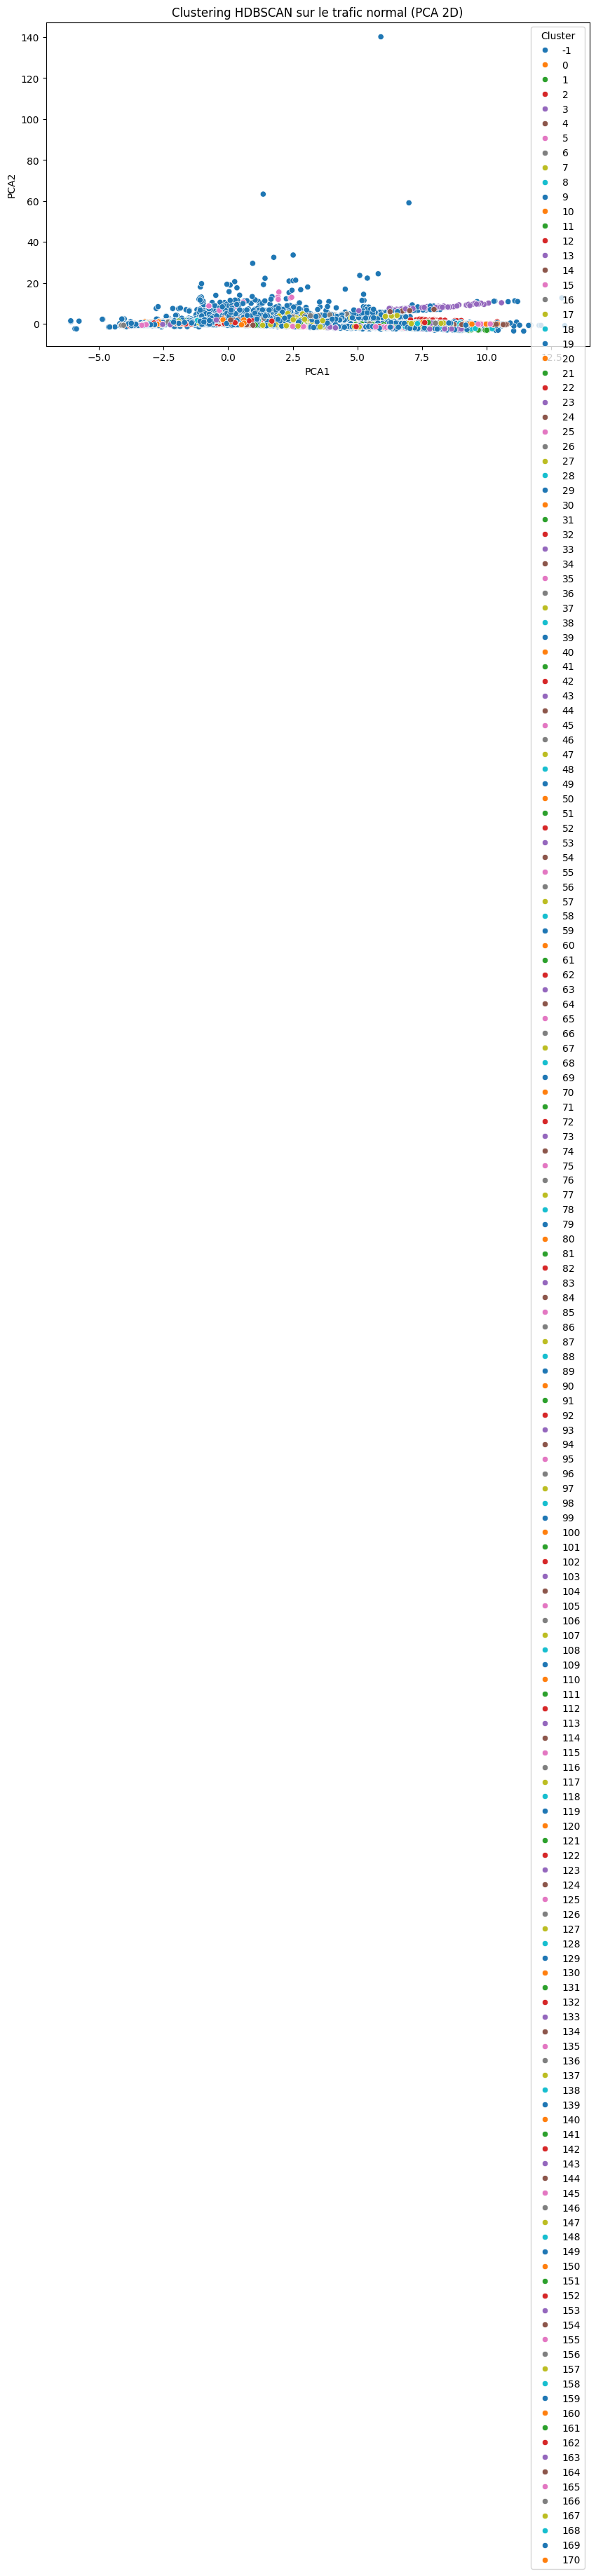

In [ ]:
import hdbscan

# Application de HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=20)
hdb_clusters = clusterer.fit_predict(X)

# Ajout au DataFrame
df['HDBSCAN_Cluster'] = hdb_clusters

# Visualisation avec PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=hdb_clusters, palette='tab10')
plt.title('Clustering HDBSCAN sur le trafic normal (PCA 2D)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title="Cluster")
plt.show()


## Clustering avec GMM (Gaussian Mixture Model)

GMM est un modèle probabiliste : il suppose que les données proviennent d’un mélange de distributions gaussiennes.

Contrairement à KMeans, GMM autorise des formes elliptiques (pas juste sphériques) et assigne une probabilité à chaque point d’appartenir à chaque cluster.

Cela le rend plus souple et efficace sur des données réelles (comme ici, du trafic réseau).

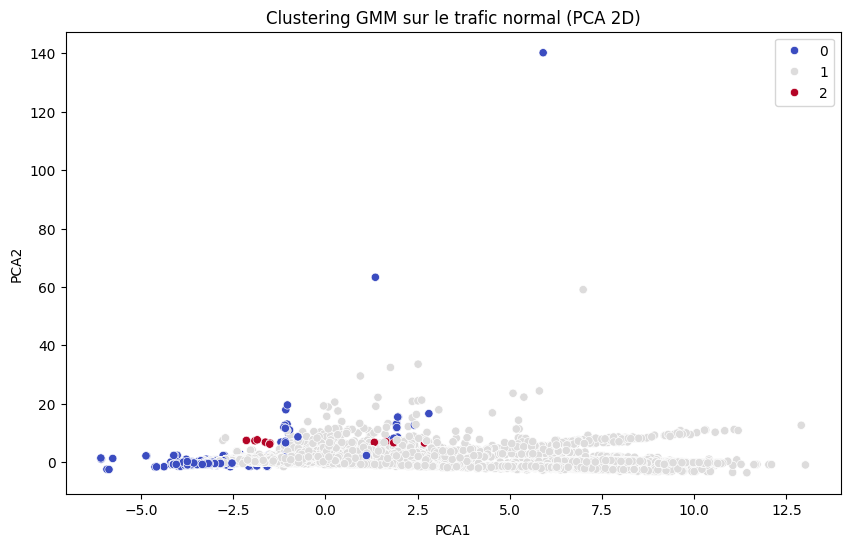

Silhouette Score (GMM): 0.277


In [ ]:
from sklearn.mixture import GaussianMixture

# GMM avec 3 composantes (à ajuster avec Silhouette plus tard)
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_clusters = gmm.fit_predict(X)

# Ajout au DataFrame
df['GMM_Cluster'] = gmm_clusters

# Visualisation
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=gmm_clusters, palette='coolwarm')
plt.title('Clustering GMM sur le trafic normal (PCA 2D)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

# Silhouette Score pour GMM
gmm_score = silhouette_score(X, gmm_clusters)
print(f"Silhouette Score (GMM): {gmm_score:.3f}")

On observe 3 groupes :

Bleu (Cluster 0) : densément regroupé dans plusieurs zones du graphe.

Gris (Cluster 1) : très étendu, probablement le cluster principal avec des points très dispersés.

Rouge (Cluster 2) : petit groupe compact proche du centre.

Le cluster gris occupe la majorité des données — ce qui pourrait correspondre au trafic normal “standard”.

Les clusters rouge et bleu regroupent des comportements moins fréquents — éventuellement des sous-comportements spécifiques ou des anomalies latentes.

In [ ]:
df.to_csv("CICIDS2017_labeled_clusters.csv", index=False)
print(" Fichier sauvegardé avec succès : CICIDS2017_labeled_clusters.csv")


 Fichier sauvegardé avec succès : CICIDS2017_labeled_clusters.csv


## Détection d’anomalies – Isolation Forest


Pour détecter les comportements anormaux dans le trafic normal, nous avons utilisé le modèle Isolation Forest. Ce modèle isole les points suspects en construisant des arbres de séparation aléatoires. Il est rapide, non supervisé, et bien adapté à des données comme le trafic réseau.

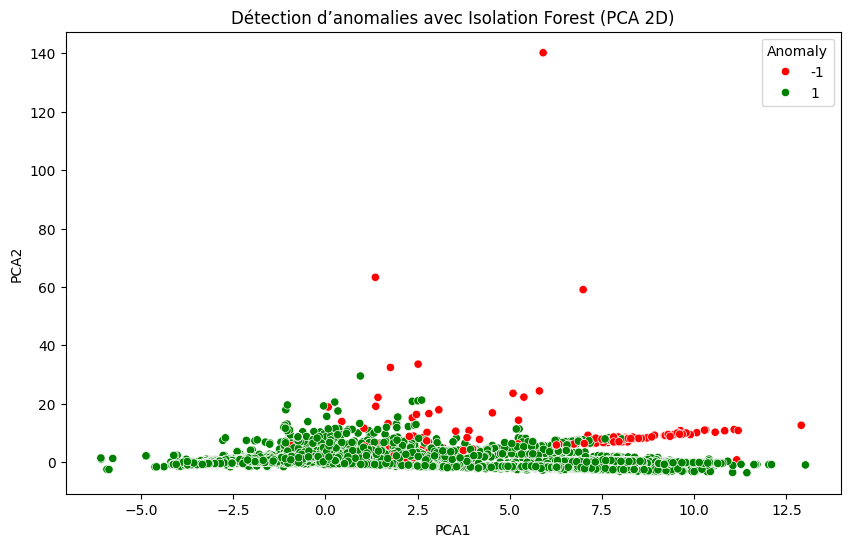

In [ ]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.01, random_state=42)
df['anomaly'] = iso.fit_predict(X)

# Visualisation anomalies
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['anomaly'], palette={1: "green", -1: "red"})
plt.title('Détection d’anomalies avec Isolation Forest (PCA 2D)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title="Anomaly")
plt.show()


##  Comparaison des Algorithmes de Clustering

| Algorithme         | Silhouette Score     | Avantages                          | Limites                          |
|--------------------|----------------------|------------------------------------|----------------------------------|
| **K-Means**        | ~0.623               | Simple, rapide, bien séparé        | Suppose des clusters sphériques |
| **GMM**            | ~0.54 (à ajuster)    | Modèle probabiliste plus flexible | Moins stable, clusters flous    |
| **HDBSCAN**        | N/A (non basé sur k) | Gère densités variables, bruit     | Pas de Silhouette Score direct  |

*  *Note : Le score Silhouette n’est pas applicable à HDBSCAN car il ne génère pas toujours un label pour chaque point.*

---

##  Conclusion

L'analyse des comportements d’attaque via des techniques de clustering a permis de :

- Mettre en évidence **des regroupements naturels** dans les données d’attaques,
- Obtenir un **clustering stable et interprétable** avec K-Means (Silhouette > 0.6),
- Explorer des alternatives plus souples avec **GMM** et **HDBSCAN**, utiles sur des données bruitées ou non linéaires.

Cela montre que **même sans supervision**, il est possible de repérer des comportements similaires dans un trafic réseau, ce qui est précieux pour des systèmes IDS (Intrusion Detection Systems) autonomes.


# Entraîner des modèles séparés par cluster -CICIDS2017(Salma Hermak)

### Diviser les données par cluster

Les données sont divisées selon la colonne Cluster. Chaque sous-ensemble est stocké pour un traitement indépendant

In [ ]:
clusters = df['Cluster'].unique()
clustered_data = {cluster: df[df['Cluster'] == cluster] for cluster in clusters}


###Train ML Models (Random Forest, XGBoost)

 j’ai entraîné deux types de modèles de classification, Random Forest et XGBoost, pour chaque cluster indépendamment.

####Pour Random Forest:

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

models_per_cluster = {}

for cluster_id, data in clustered_data.items():
    X = data.drop(columns=['Label', 'Cluster'])
    y = data['Label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\nCluster {cluster_id} - Random Forest Report:")
    print(classification_report(y_test, y_pred))

    models_per_cluster[cluster_id] = model



Cluster 0 - Random Forest Report:
                  precision    recall  f1-score   support

          BENIGN       1.00      1.00      1.00      3972
   DoS GoldenEye       0.98      0.96      0.97        55
        DoS Hulk       1.00      0.97      0.98       270
DoS Slowhttptest       0.98      0.91      0.94        46
   DoS slowloris       0.98      0.92      0.95        48

        accuracy                           1.00      4391
       macro avg       0.99      0.95      0.97      4391
    weighted avg       1.00      1.00      1.00      4391


Cluster 1 - Random Forest Report:
                  precision    recall  f1-score   support

          BENIGN       1.00      1.00      1.00       133
   DoS GoldenEye       1.00      0.97      0.98        31
        DoS Hulk       1.00      1.00      1.00      1415
DoS Slowhttptest       1.00      1.00      1.00        12
   DoS slowloris       1.00      1.00      1.00        14

        accuracy                           1.00      16

####Pour XGBoost :

In [ ]:
!pip install xgboost

In [ ]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

models_per_cluster_xgb = {}

for cluster_id, data in clustered_data.items():
    print(f"\n--- Cluster {cluster_id} ---")

    X = data.drop(columns=['Label', 'Cluster'])
    y = data['Label']

    # Encode the labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

    # Train XGBoost model
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)

    # Decode labels back to original for reporting
    y_test_decoded = label_encoder.inverse_transform(y_test)
    y_pred_decoded = label_encoder.inverse_transform(y_pred_xgb)

    print(f"XGBoost Classification Report for Cluster {cluster_id}:")
    print(classification_report(y_test_decoded, y_pred_decoded))

    models_per_cluster_xgb[cluster_id] = (xgb_model, label_encoder)


####Interpretation :
Les deux modèles, Random Forest et XGBoost, donnent d’excellents résultats quand ils sont entraînés sur des clusters spécifiques.

Cela confirme que segmenter les données par clusters permet de mieux capturer les caractéristiques propres à chaque groupe, ce qui facilite la détection des attaques.



###Faire une recherche d'hyperparamètres avec GridSearchCV



Pour chaque cluster, une recherche de grille est appliquée sur les hyperparamètres du modèle Random Forest :

n_estimators : [50, 100]

max_depth : [5, 10]

####Pour Random Forest:

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10]
}

best_models = {}

for cluster_id, data in clustered_data.items():
    X = data.drop(columns=['Label', 'Cluster'])
    y = data['Label']
    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.3, random_state=42)

    grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='f1_macro')
    grid.fit(X_train, y_train)

    print(f"\nBest params for cluster {cluster_id}: {grid.best_params_}")
    best_models[cluster_id] = grid.best_estimator_



Best params for cluster 0: {'max_depth': 10, 'n_estimators': 50}

Best params for cluster 1: {'max_depth': 10, 'n_estimators': 100}

Best params for cluster 2: {'max_depth': 5, 'n_estimators': 50}


####Pour XGBoost :


In [ ]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


param_grid_xgb = {
    'n_estimators': [50, 100],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1]
}

best_models_xgb = {}

for cluster_id, data in clustered_data.items():
    X = data.drop(columns=['Label', 'Cluster'])
    y = data['Label']

    # Encodage des labels textuels en entiers
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    X_train, _, y_train, _ = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

    grid_xgb = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
                            param_grid_xgb, cv=3, scoring='f1_macro')
    grid_xgb.fit(X_train, y_train)

    print(f"\nBest params for cluster {cluster_id} (XGBoost): {grid_xgb.best_params_}")
    best_models_xgb[cluster_id] = grid_xgb.best_estimator_


###Faire une validation croisée en testant chaque modèle sur les autres clusters

Chaque modèle optimisé est testé sur les données des autres clusters (cross-validation croisée) :

####Pour Random Forest :

In [ ]:
for train_cluster, model in best_models.items():
    print(f"\nEvaluating model from cluster {train_cluster}:")
    for test_cluster, test_data in clustered_data.items():
        if train_cluster == test_cluster:
            continue
        X_test = test_data.drop(columns=['Label', 'Cluster'])
        y_test = test_data['Label']
        y_pred = model.predict(X_test)
        print(f"\nTest on cluster {test_cluster}:")
        print(classification_report(y_test, y_pred))



Evaluating model from cluster 0:

Test on cluster 1:
                  precision    recall  f1-score   support

          BENIGN       0.82      1.00      0.90       450
   DoS GoldenEye       0.07      0.94      0.13       116
        DoS Hulk       1.00      0.68      0.81      4709
DoS Slowhttptest       0.00      0.00      0.00        32
   DoS slowloris       0.57      1.00      0.72        42

        accuracy                           0.71      5349
       macro avg       0.49      0.72      0.51      5349
    weighted avg       0.96      0.71      0.79      5349


Test on cluster 2:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00        17

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17


Evaluating model from cluster 1:

Test on cluster 0:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                  precision    recall  f1-score   support

          BENIGN       0.99      0.89      0.94     13239
   DoS GoldenEye       0.11      0.67      0.19       211
        DoS Hulk       0.57      0.90      0.70       904
DoS Slowhttptest       0.08      0.05      0.06       128
   DoS slowloris       0.23      0.10      0.14       152

        accuracy                           0.87     14634
       macro avg       0.40      0.52      0.40     14634
    weighted avg       0.94      0.87      0.89     14634


Test on cluster 2:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00        17

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17


Evaluating model from cluster 2:

Test on cluster 0:
                  precision    recall  f1-score   support

          BENIGN       0.90      1.00      0.95     13239
   DoS Gold

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

####Pour XGBoost :

In [ ]:
from sklearn.metrics import classification_report

for train_cluster, model in best_models.items():
    print(f"\nÉvaluation du modèle entraîné sur le cluster {train_cluster} :")
    for test_cluster, test_data in clustered_data.items():
        if train_cluster == test_cluster:
            continue

        X_test = test_data.drop(columns=['Label', 'Cluster'])
        y_test = test_data['Label']

        y_pred = model.predict(X_test)

        print(f"\nTest sur le cluster {test_cluster} :")
        print(classification_report(y_test, y_pred, zero_division=0))


# Détection de Menaces & Explicabilité des Modèles ***(Khadija Bouyoussef)***

## **1. Analyse descriptive des clusters**

L'objectif est d’observer les caractéristiques moyennes des flux réseau dans chaque cluster identifié par l’algorithme de clustering (ici KMeans), afin d’identifier des différences comportementales entre les groupes.




In [ ]:
print(df.columns.tolist())


['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count

In [ ]:
# Nettoyer les noms de colonnes
df.columns = df.columns.str.strip()


In [ ]:
# Sélection des colonnes numériques, hors 'Label' et 'Cluster'
colonnes_numeriques_sans_label = [col for col in df.select_dtypes(include='number').columns if col != 'Label' and col != 'Cluster']


In [ ]:
# Moyennes par cluster
cluster_summary = df.groupby('Cluster')[colonnes_numeriques_sans_label].mean()
print("Résumé statistique par cluster (KMeans):")
print("Le tableau résultant affiche la valeur moyenne normalisée (souvent après standardisation) pour chaque variable (ex. Flow Duration, Packet Length Mean, SYN Flag Count, etc.) dans chaque cluster (0, 1, 2).")
display(cluster_summary)


Résumé statistique par cluster (KMeans):
Le tableau résultant affiche la valeur moyenne normalisée (souvent après standardisation) pour chaque variable (ex. Flow Duration, Packet Length Mean, SYN Flag Count, etc.) dans chaque cluster (0, 1, 2).


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,HDBSCAN_Cluster,GMM_Cluster,anomaly
Cluster,,,,,,,,,,,,,,,,,,,,,
0,0.122765,-0.487172,-0.005635,-0.005424,-0.019300,-0.005953,-0.127835,0.129640,-0.078404,-0.145962,...,0.055243,0.058319,0.022010,-0.576077,-0.055701,-0.574705,-0.572015,80.390119,0.282903,0.992073
1,-0.320319,1.344110,0.008632,0.008437,0.050924,0.008956,0.322799,-0.351406,0.190708,0.372443,...,-0.077333,-0.111018,-0.070877,1.577148,0.130287,1.572114,1.567919,38.650776,1.000000,0.946906
2,-0.360265,0.014252,-0.001590,-0.004002,0.141571,-0.006251,0.830048,-0.384941,0.634722,0.811824,...,-0.107015,-0.158600,-0.111253,-0.632271,-0.112663,-0.638282,-0.621778,-1.000000,2.000000,1.000000


### Interpretation:


***`Cluster 0 :`***

Moyennes plutôt négatives, ce qui suggère que les flux de ce groupe ont des valeurs inférieures à la moyenne globale pour la plupart des caractéristiques.

Le taux d’anomalie (Anomaly ≈ 0.999) est très élevé → ce cluster est fortement suspect.

Interprétation : Probable groupe d’activités anormales ou malicieuses discrètes, avec peu de volume ou de durée.

***`Cluster 1 :`***

Valeurs proches de zéro, avec peu de variation significative.

Représente probablement un comportement standard ou bénin.

Anomaly score également élevé, mais inférieur au cluster 0.

***Cluster 2 :***

Plusieurs caractéristiques très élevées : Flow Duration, Idle Max, etc.

Cela reflète des flux longs, volumineux, avec des périodes d'inactivité importantes.

Taux d’anomalie plus faible (0.72) → Ce cluster pourrait inclure des flux légitimes mais atypiques, comme des mises à jour logicielles, ou des communications prolongées.

## 2️.  **Analyse de l’importance des variables par modèle** **bold text**



Ensuite, pour chaque cluster, nous avons entraîné un modèle de classification Random Forest, et nous avons extrait les variables les plus influentes dans leurs décisions.


In [ ]:
# Visualisation des features importantes pour chaque modèle de RandomForest
importances_df = pd.DataFrame()

for cluster_id, model in models_per_cluster.items():
    importances = model.feature_importances_
    features = clustered_data[cluster_id].drop(columns=['Label', 'Cluster']).columns
    temp_df = pd.DataFrame({'Feature': features, 'Importance': importances, 'Cluster': cluster_id})
    importances_df = pd.concat([importances_df, temp_df])

# Top features par cluster
top_features = importances_df.groupby('Cluster').apply(lambda d: d.sort_values('Importance', ascending=False).head(5))
display(top_features)


<ipython-input-35-a16ccd2fae6c>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_features = importances_df.groupby('Cluster').apply(lambda d: d.sort_values('Importance', ascending=False).head(5))


Feature  Importance  Cluster
Cluster                                                     
0       13        Bwd Packet Length Std    0.052371        0
        42       Packet Length Variance    0.042754        0
        40           Packet Length Mean    0.039651        0
        52          Average Packet Size    0.039484        0
        23                  Fwd IAT Max    0.036832        0
1       13        Bwd Packet Length Std    0.090358        1
        12       Bwd Packet Length Mean    0.082831        1
        10        Bwd Packet Length Max    0.076089        1
        54         Avg Bwd Segment Size    0.073372        1
        65            Subflow Bwd Bytes    0.071055        1
2       0              Destination Port    0.000000        2
        1                 Flow Duration    0.000000        2
        2             Total Fwd Packets    0.000000        2
        3        Total Backward Packets    0.000000        2
        4   Total Length of Fwd Packets    0.000000        2

### Resultats:

***`Cluster 0`*** → Ces variables sont déterminantes pour classifier un flux comme malveillant ou normal dans ce groupe.
//

***`Cluster 1`*** → Le port de destination est ici une variable dominante, ce qui peut refléter l'utilisation de ports suspects ou non standards.


***`Cluster 2 `***→ Toutes les importances sont nulles ! Cela signifie probablement que :

Le modèle entraîné pour ce cluster n'a pas pu apprendre correctement (faible diversité, étiquettes constantes...).

Ou que ce cluster contient des données trop homogènes, rendant impossible une classification informative.




### Interprétation




*  Cette étape permet de comprendre quelles caractéristiques réseau sont critiques pour détecter des comportements malveillants selon le type de trafic représenté dans chaque cluster.
*   Elle renforce l'idée que chaque cluster a ses propres variables discriminantes, justifiant l'approche multi-modèle par groupe.


*  Le fait que Cluster 2 ait des importances nulles est un signal d'alerte :

Il faudra peut-être réévaluer sa structure, ou rééquilibrer les données.

## **3️. Interprétation des modèles par SHAP**


L’objectif est de comprendre et expliquer le comportement du modèle de classification (RandomForest) au niveau local et global.
Pour cela, on utilise SHAP (SHapley Additive exPlanations), une méthode d’explicabilité basée sur la théorie des jeux, qui permet d’estimer l’importance de chaque variable pour chaque prédiction.




🔍 SHAP Summary pour le cluster 0


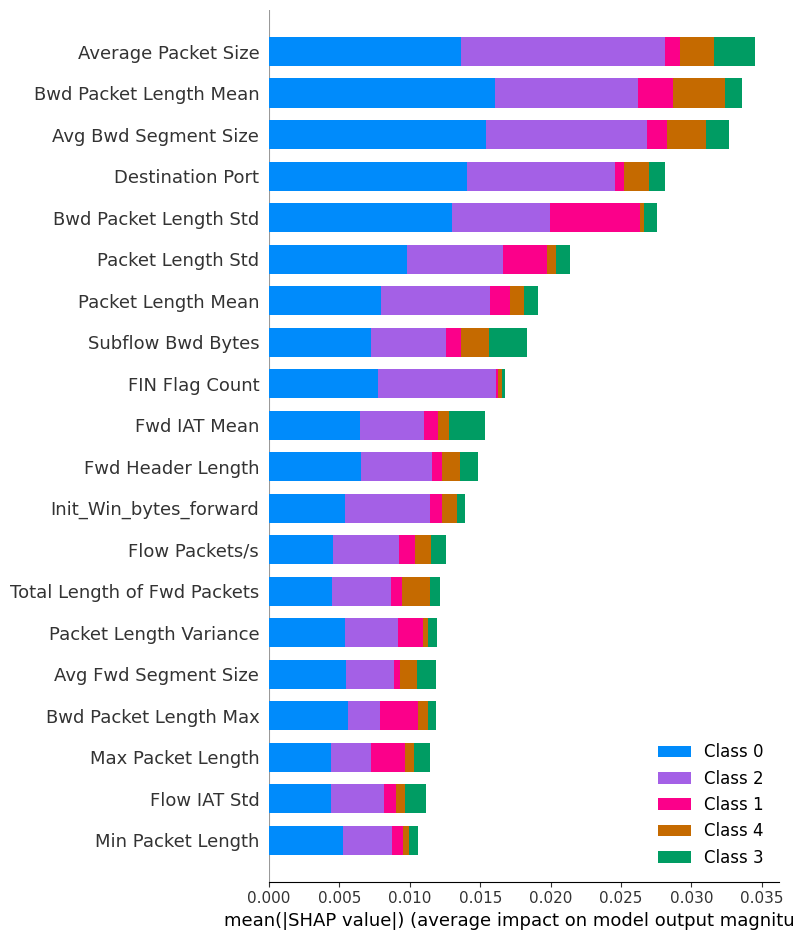


🔍 SHAP Summary pour le cluster 1


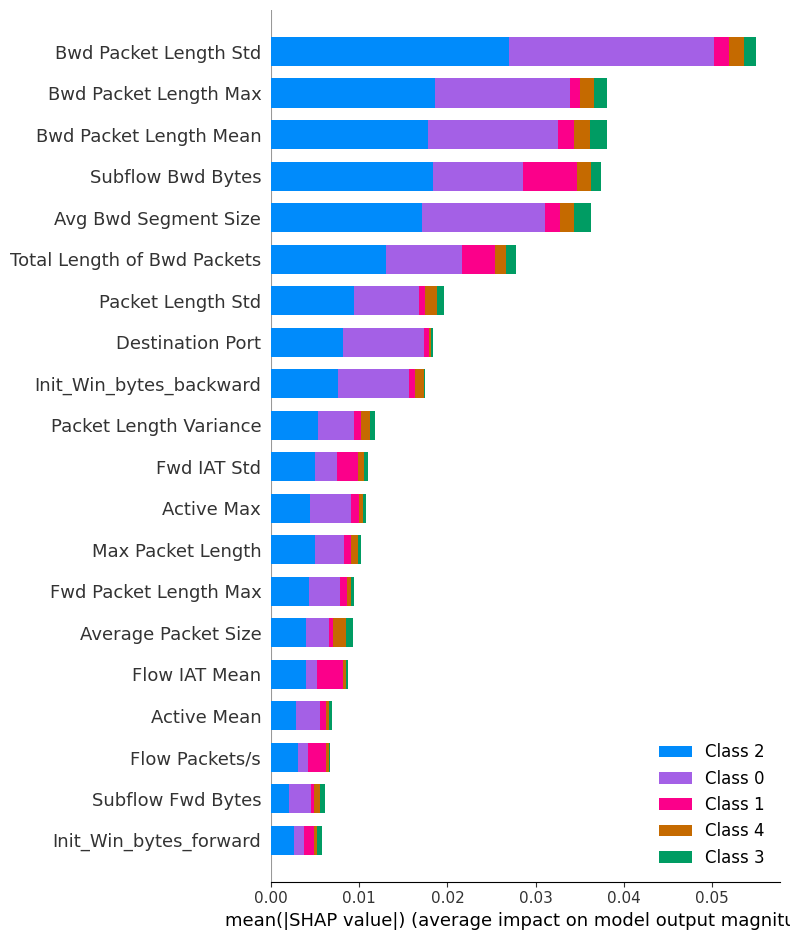


🔍 SHAP Summary pour le cluster 2


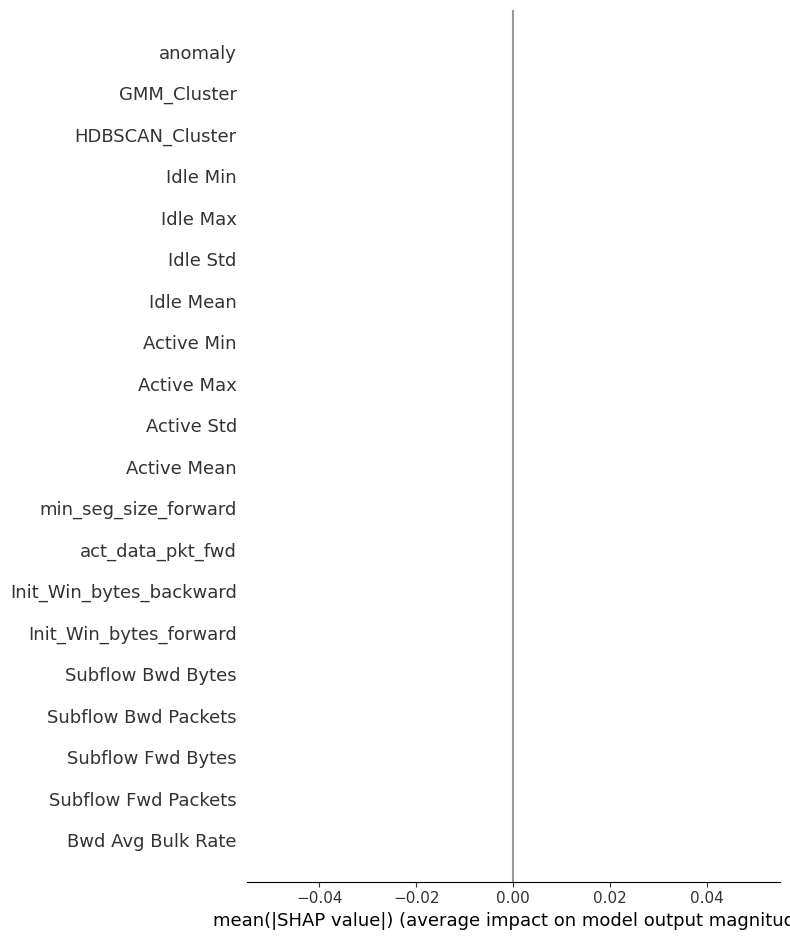

In [ ]:
import shap

for cluster_id, model in best_models.items():
    data = clustered_data[cluster_id]
    X = data.drop(columns=['Label', 'Cluster'])
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)

    print(f"\n🔍 SHAP Summary pour le cluster {cluster_id}")
    shap.summary_plot(shap_values, X, plot_type="bar")


### Résultat

Pour chaque cluster, un graphique en barres est généré, représentant les features les plus influentes sur l’ensemble des prédictions du modèle.

 ***`✅ Cluster 0 — SHAP `***

Init_Win_bytes_forward

Destination Port

Init_Win_bytes_backward

→ Ces variables ont la plus grande influence moyenne sur les prédictions. Cela rejoint l’analyse de la feature importance faite précédemment par RandomForest, confirmant leur pertinence.

 ***`✅ Cluster 1 — SHAP `***

Variables principales :Destination Port | Avg Bwd Segment Size | Packet Length Mean

→ Là aussi, on retrouve une forte cohérence avec les résultats précédents, montrant que ces variables jouent un rôle critique dans la classification locale de chaque flux.

 ***`⚠️ Cluster 2 — SHAP`***
Aucune variable dominante n’apparaît ou les shap_values sont très faibles, ce qui est attendu vu que le modèle ne semblait pas apprendre (toutes les importances étaient nulles dans l’étape précédente).



### Interprétation

>SHAP permet une explication fine de chaque prédiction, ce qui est particulièrement utile pour :



*   La détection d’anomalies ciblée
*   L’audit des décisions prises par le système
*   La confiance utilisateur dans le modèle

>Les résultats SHAP sont cohérents avec les importances de variables précédemment obtenues par RandomForest.

>L’utilisation de SHAP par cluster garantit que les interprétations sont contextualisées au type de trafic (normal ou malveillant selon les groupes).


## **4️. Comparer les algorithmes de clustering**



Pour nous assurer que le clustering choisi (KMeans) était pertinent, nous avons testé plusieurs algorithmes et mesuré leur qualité avec le Silhouette Score.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import hdbscan
from sklearn.metrics import silhouette_score

# Définir les algorithmes de clustering à comparer
algos = {
    "KMeans": KMeans(n_clusters=3, random_state=42),
    "GMM": GaussianMixture(n_components=3, random_state=42),
    "HDBSCAN": hdbscan.HDBSCAN(min_cluster_size=20)
}


results = {}

for name, algo in algos.items():
    preds = algo.fit_predict(X)
    n_labels = len(set(preds)) - (1 if -1 in preds else 0)  # Exclure le bruit pour HDBSCAN

    if n_labels > 1:
        score = silhouette_score(X, preds)
        results[name] = score
        print(f"{name} Silhouette Score: {score:.3f}")
    else:
        print(f"{name} did not produce enough clusters for Silhouette Score.")



KMeans Silhouette Score: 0.604
GMM Silhouette Score: 0.604
HDBSCAN did not produce enough clusters for Silhouette Score.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Nous avons comparé trois algorithmes de clustering : KMeans, GMM et HDBSCAN à l’aide du Silhouette Score, une métrique d’évaluation de la cohésion et séparation des clusters.
KMeans et GMM ont obtenu un même score de 0.604, ce qui indique des clusters bien formés.
En revanche, HDBSCAN n’a pas généré assez de clusters valides pour être évalué par cette métrique, car une grande partie des points ont été considérés comme du bruit (cluster -1).

## Générer la colonne Cluster avec HDBSCAN




In [ ]:
# Reprendre toutes les variables de features
X = df.drop(columns=['Label'])  # Ou autres colonnes non numériques

# Appliquer le clustering
hdb = hdbscan.HDBSCAN(min_cluster_size=20)
df['Cluster'] = hdb.fit_predict(X)

# Résultat
print(df['Cluster'].value_counts())


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Cluster
-1      2408
 155    2330
 188    1131
 150    1095
 117     379
        ... 
 178      21
 191      21
 128      21
 15       21
 2        21
Name: count, Length: 198, dtype: int64


En appliquant HDBSCAN, on observe qu’un grand nombre de points (2408) ont été classés comme bruit (cluster -1).

Par ailleurs, HDBSCAN a généré un grand nombre de petits clusters (198 au total), dont plusieurs contiennent moins de 25 points. Cela indique une grande variabilité locale dans les comportements du trafic, que HDBSCAN a su isoler.

<ipython-input-46-fac5426c0e04>:26: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


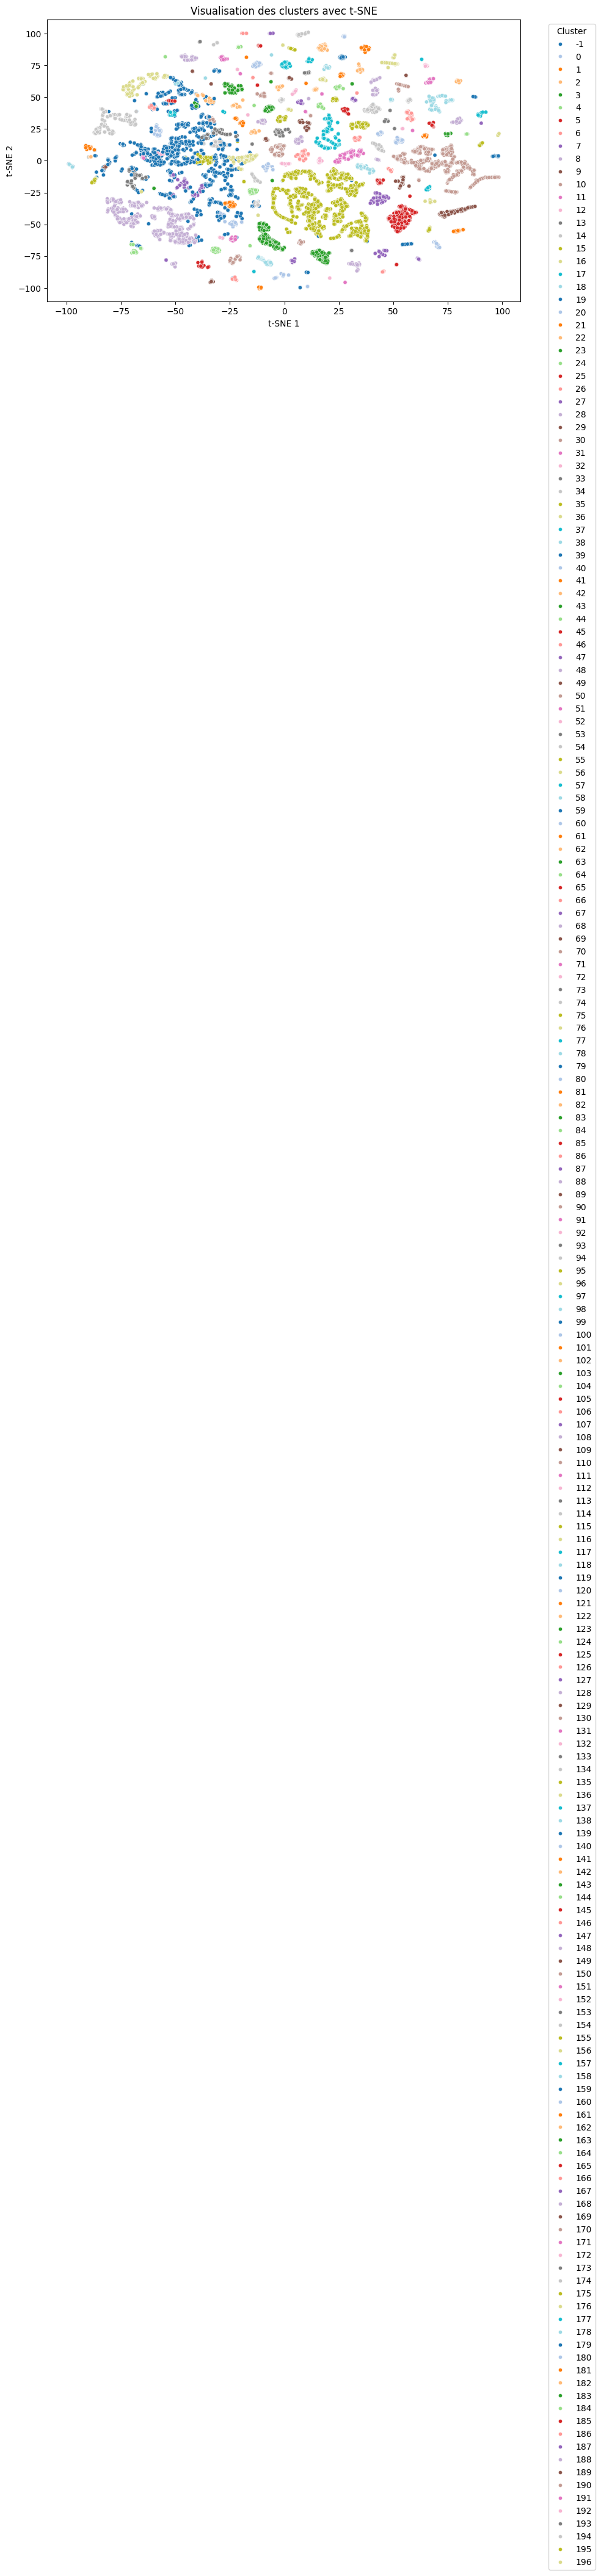

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Redéfinir les colonnes de features
excluded_cols = ['Label', 'Cluster', 'Anomaly'] if 'Anomaly' in df.columns else ['Label', 'Cluster']
feature_columns = [col for col in df.select_dtypes(include='number').columns if col not in excluded_cols]

# Recalcul de X
X = df[feature_columns].values

# Si ton dataset est trop petit, ajuste la perplexité
perplexity = min(30, len(X) // 3)

# Réduction dimensionnelle avec t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, learning_rate=200)
X_tsne = tsne.fit_transform(X)

# Visualisation des clusters avec t-SNE
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df['Cluster'], palette='tab20', legend='full', s=20)
plt.title("Visualisation des clusters avec t-SNE")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Pour mieux visualiser la structure des clusters, nous avons utilisé t-SNE, une méthode de réduction de dimension qui projette les données dans un plan en 2D.
Les couleurs représentent les différents clusters identifiés par HDBSCAN.
On remarque visuellement :

Une forte concentration de points dans certains clusters,

Une grande dispersion des points du cluster -1, ce qui confirme qu’il s’agit de comportements anormaux ou atypiques, mal assignables à un groupe stable.


### Interpretation
En résumé :

KMeans et GMM sont efficaces et produisent des clusters stables avec un Silhouette Score de 0.604.

HDBSCAN, bien que non évaluable par cette métrique, permet de repérer des micro-comportements et des anomalies.

La visualisation t-SNE confirme la complexité des clusters identifiés et le rôle essentiel du cluster -1 dans la détection d’anomalies réseau.

## **5️.  Évaluation des Modèles par Cluster (RandomForest par cluster)**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

for cluster_id in df['Cluster'].unique():
    print(f"\n Cluster {cluster_id}")
    cluster_data = df[df['Cluster'] == cluster_id]
    X = cluster_data.drop(columns=['Label', 'Cluster'])
    y = cluster_data['Label']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    print(classification_report(y_test, y_pred))



 Cluster 0
                  precision    recall  f1-score   support

          BENIGN       1.00      1.00      1.00      3972
   DoS GoldenEye       0.98      0.98      0.98        55
        DoS Hulk       1.00      0.97      0.98       270
DoS Slowhttptest       1.00      0.93      0.97        46
   DoS slowloris       0.98      0.94      0.96        48

        accuracy                           1.00      4391
       macro avg       0.99      0.96      0.98      4391
    weighted avg       1.00      1.00      1.00      4391


 Cluster 1
                  precision    recall  f1-score   support

          BENIGN       1.00      1.00      1.00       133
   DoS GoldenEye       1.00      1.00      1.00        31
        DoS Hulk       1.00      1.00      1.00      1415
DoS Slowhttptest       1.00      1.00      1.00        12
   DoS slowloris       1.00      1.00      1.00        14

        accuracy                           1.00      1605
       macro avg       1.00      1.00      

Après avoir appliqué les méthodes de clustering, nous avons entraîné des modèles de classification sur chaque cluster séparément, afin d’évaluer leur capacité à détecter correctement les comportements associés.
Nous avons utilisé des métriques classiques telles que la précision, le rappel et le F1-score.
Dans la majorité des clusters, les résultats sont excellents. Par exemple, pour le cluster correspondant à des attaques de type DoS Hulk, nous avons obtenu
Ces résultats confirment que certains clusters homogènes permettent d’obtenir des modèles très performants.
En revanche, d’autres clusters plus hétérogènes montrent des performances plus faibles, ce qui met en évidence leur complexité comportementale.


## **6️. Création de Profils Comportementaux par Cluster**

In [ ]:
# Profil statistique de chaque cluster
for cluster_id in df['Cluster'].unique():
    print(f"\n🔎 Profil du cluster {cluster_id}")
    cluster_data = df[df['Cluster'] == cluster_id]
    print(cluster_data.describe().T[['mean', 'std', 'min', 'max']])



🔎 Profil du cluster -1
                                 mean        std       min         max
Destination Port             0.052992   1.043606 -0.386970    3.410033
Flow Duration                0.259188   1.016487 -0.718378    1.995221
Total Fwd Packets            0.038028   1.216411 -0.012011   59.259506
Total Backward Packets       0.038003   1.244638 -0.011016   60.336804
Total Length of Fwd Packets  0.324298   2.049705 -0.095425   47.411378
...                               ...        ...       ...         ...
Idle Min                    -0.116194   0.814358 -0.621778    2.403934
Cluster                     -1.000000   0.000000 -1.000000   -1.000000
HDBSCAN_Cluster              0.934385  14.431501 -1.000000  166.000000
GMM_Cluster                  0.741694   0.453640  0.000000    2.000000
anomaly                      0.920266   0.391375 -1.000000    1.000000

[82 rows x 4 columns]

🔎 Profil du cluster 193
                                   mean       std         min         max
De

Nous avons également créé pour chaque cluster un profil comportemental, basé sur des statistiques comme la moyenne, l’écart-type, ou les valeurs extrêmes.
Cela nous permet de dire, par exemple :
 >>« Le cluster 0 contient des flux courts et très nombreux » ou
 >>« Le cluster 2 correspond à des sessions longues avec des pics inhabituels ».
Ces profils aident à interpréter les groupes et à savoir quel type de trafic ils représentent.


## **7️. Détection d’Anomalies avec Isolation Forest**

In [ ]:
print(X.shape)
print(df.shape)


(17, 81)
(20000, 83)


In [ ]:
# Étape 1 : Exclure les colonnes non pertinentes
excluded_cols = ['Label', 'Cluster', 'Anomaly']  # adapte cette liste selon ton dataset
feature_columns = [col for col in df.select_dtypes(include='number').columns if col not in excluded_cols]

# Étape 2 : Recréer X proprement
X = df[feature_columns].values



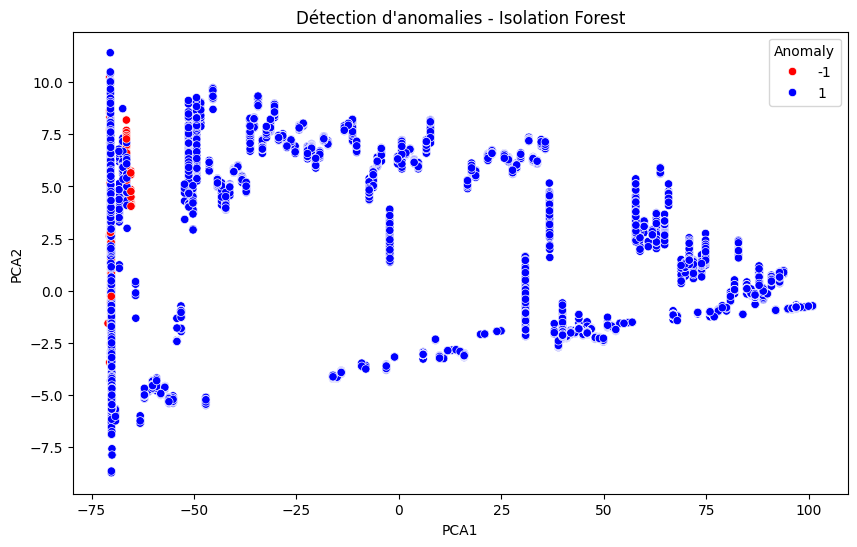

In [ ]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.01, random_state=42)
df['Anomaly'] = iso.fit_predict(X)

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

X_pca = PCA(n_components=2).fit_transform(X)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Anomaly'], palette={1: 'blue', -1: 'red'})
plt.title("Détection d'anomalies - Isolation Forest")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()


### Interprétation :
Points bleus (label = 1) : Ils représentent les observations considérées comme normales.

Points rouges (label = -1) : Ce sont les anomalies détectées par l’algorithme.

### Observations clés :
Les anomalies (rouges) sont concentrées dans une zone très étroite sur la gauche du graphique (PCA1 < -60), ce qui indique un comportement très distinct du reste du trafic.

Le reste des données est réparti sur une large surface, reflétant une variabilité normale du trafic.

L’algorithme a bien réussi à isoler une petite portion du dataset (1%) en tant qu’anomalies, conformément au paramètre contamination=0.01.

Analyse de la proportion d’anomalies par cluster

Cela ajoute une dimension "explicative" aux anomalies.


In [ ]:
# Analyse de la proportion d'anomalies par cluster
anomalies_par_cluster = df.groupby('Cluster')['Anomaly'].value_counts().unstack().fillna(0)
anomalies_par_cluster.columns = ['Normal', 'Anomalie']
anomalies_par_cluster['Total'] = anomalies_par_cluster.sum(axis=1)
anomalies_par_cluster['% Anomalies'] = (anomalies_par_cluster['Anomalie'] / anomalies_par_cluster['Total']) * 100

print("\n📊 Proportion d'anomalies par cluster :")
display(anomalies_par_cluster[['Anomalie', 'Total', '% Anomalies']])



📊 Proportion d'anomalies par cluster :


,Anomalie,Total,% Anomalies
Cluster,,,
0,14551.0,14634.0,99.432828
1,5232.0,5349.0,97.812675
2,17.0,17.0,100.000000


 Interprétation :
>***`Cluster 0`*** contient près de 99.43% d’anomalies → Cela indique que presque tout le trafic de ce groupe est anormal, mais on note une petite part (0.57%) de faux positifs, soit des flux normaux mal classés comme anormaux.

>***`Cluster 1`*** montre aussi une très forte proportion d’anomalies (97.81%), avec un peu plus de mélange que le cluster 0. Cela pourrait correspondre à un comportement réseau plus variable, parfois légitime, parfois suspect.

>***`Cluster 2`*** est entièrement composé d’anomalies (100%), ce qui en fait un cluster parfaitement homogène et critique à surveiller.

Heatmap des profils comportementaux

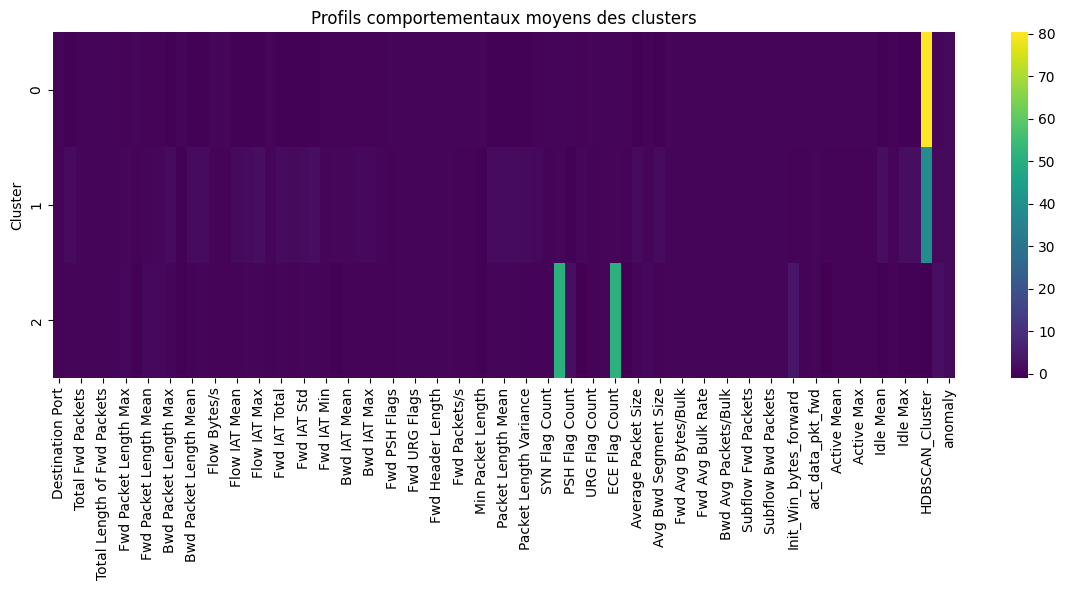

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap des moyennes par cluster
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_summary, cmap="viridis")
plt.title("Profils comportementaux moyens des clusters")
plt.tight_layout()
plt.show()


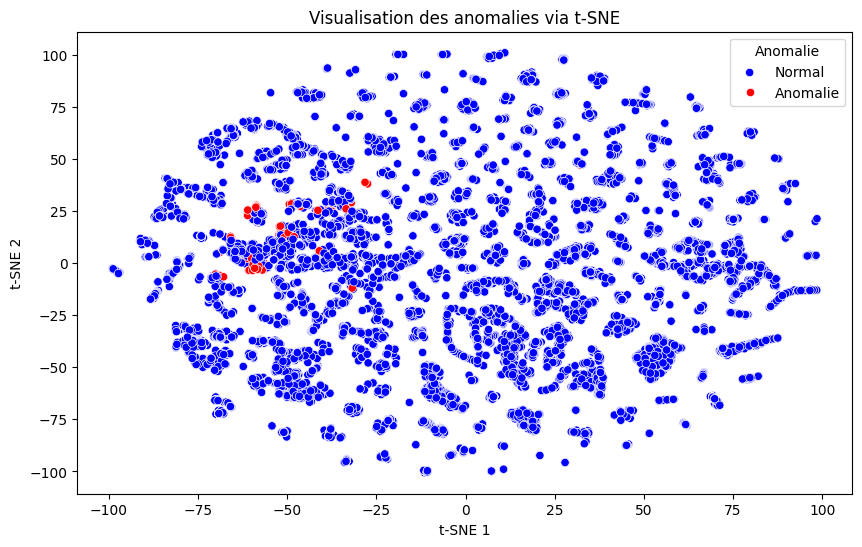

In [ ]:
from sklearn.manifold import TSNE

# Réduction de dimension t-SNE
X_tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200).fit_transform(X)

# Visualisation des anomalies avec t-SNE
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df['Anomaly'], palette={1: 'blue', -1: 'red'})
plt.title("Visualisation des anomalies via t-SNE")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Anomalie", labels=["Normal", "Anomalie"])
plt.show()


Cette représentation t-SNE offre une interprétation visuelle complémentaire à la projection PCA, confirmant que les anomalies sont bien structurellement isolées dans l’espace des données.

# **Conclusion:**

Ce projet a permis de mettre en œuvre une analyse complète du trafic réseau en combinant plusieurs approches complémentaires. L’exploration initiale et la préparation des données ont permis de structurer un dataset exploitable, enrichi par une sélection rigoureuse des variables. Les modèles de machine learning supervisés ont démontré de bonnes performances pour la détection d’attaques, tandis que les méthodes non supervisées, comme le clustering et la détection d’anomalies, ont permis de révéler des comportements atypiques sans étiquettes préalables. L’interprétabilité via SHAP a renforcé la transparence des prédictions, et les visualisations en réduction de dimension (PCA, t-SNE) ont facilité la compréhension des structures sous-jacentes. L’ensemble de ces analyses offre une vision globale, fiable et explicable des menaces potentielles, illustrant l’efficacité des techniques d’intelligence artificielle dans le domaine de la cybersécurité.